In [122]:
#pip install datadog-api-client

Note: you may need to restart the kernel to use updated packages.


# Initialize Datadog

In [1]:
import pandas as pd
import datadog
from datadog import initialize
from datadog import api
import time
from datetime import datetime
import numpy as np

pd.set_option('display.float_format', lambda x: '%.3f' % x)

exec(open('/home/jovyan/personal/Ray/setup_env.py').read())

initialize(
    api_key=os.environ.get('DD_API_KEY'),
    app_key=os.environ.get('DD_APP_KEY'),
    statsd_host="127.0.0.1",
    statsd_port=8125
)

"""
test = api.Metric.query(start=int(time.time()) - 3600, end=int(time.time()),
query='avg:system.cpu.idle{*}')

test = api.Metric.query(start=int(time.time()) - 36000, end=int(time.time()),
query='cutoff_max(avg:system.mem.pct_usable{*}, 0.3)')

test = api.Metric.list(int(time.time()) - 3600)

len(test['metrics'])
test['metrics'][2100:2200]


test = api.Metric.query(start=int(time.time()) - 36000, end=int(time.time()),
query='avg:system.mem.pct_usable{*} by {uq-environmentname}')
"""

"\ntest = api.Metric.query(start=int(time.time()) - 3600, end=int(time.time()),\nquery='avg:system.cpu.idle{*}')\n\ntest = api.Metric.query(start=int(time.time()) - 36000, end=int(time.time()),\nquery='cutoff_max(avg:system.mem.pct_usable{*}, 0.3)')\n\ntest = api.Metric.list(int(time.time()) - 3600)\n\nlen(test['metrics'])\ntest['metrics'][2100:2200]\n\n\ntest = api.Metric.query(start=int(time.time()) - 36000, end=int(time.time()),\nquery='avg:system.mem.pct_usable{*} by {uq-environmentname}')\n"

# Use Datadog Package to import Metrics (Singe Timeframe)

In [2]:
days = 30
test = api.Metric.query(start=int(time.time()) - 3600*24*(days/2), end=int(time.time()) - 3600*24*((days-1)/2),
        query='avg:system.mem.pct_usable{uq-environmentname:*} by {uq-environmentname}')


test=test['series']
env_list = [x['tag_set'][0] for x in test]
df = pd.DataFrame()

for e in env_list:
    list1 = [x['pointlist'] for x in test if x['tag_set'][0]==e]
    df1 = pd.DataFrame(list1).transpose().rename(columns={0:'pointlist'})
    df1['time'] = pd.to_datetime(df1.pointlist.apply(lambda x: x[0]*1000000))
    df1['freeMem'] = df1.pointlist.apply(lambda x: x[1])
    df1['client_env'] = re.sub('uq-environmentname:','',e)
    df = df.append(df1)
    
df['client'] = df.client_env
uat_list = ['uat','qa-uat','staging','dev-uat','sandbox-uat','production','preprod-production']
for a in uat_list:
    df['client'] = np.where(df.client_env.str.contains(a),df.client_env.apply(lambda x: re.sub('-'+a,'',x)),df.client)
df['env'] = df.apply(lambda x: re.sub(x.client+'-','',x.client_env),axis=1)
   
df2 = df.groupby(['client','env']).freeMem.describe().reset_index()
df2.loc[(df2['min']<=.3)|(df2['min']>.6)]

client         env   count  mean   std   min   25%   50%   75%  \
4             andino         uat 360.000 0.664 0.003 0.660 0.661 0.662 0.666   
8           aon-afty  production 360.000 0.294 0.012 0.261 0.289 0.297 0.304   
17          assurant  production 360.000 0.660 0.003 0.636 0.660 0.660 0.661   
21               axa  production 360.000 0.644 0.003 0.633 0.643 0.644 0.646   
22               axa      qa-uat 360.000 0.314 0.013 0.278 0.305 0.316 0.324   
44               boa     staging 360.000 0.680 0.000 0.679 0.680 0.680 0.680   
63          chil-crr  production 360.000 0.622 0.004 0.604 0.619 0.622 0.625   
74               cpc  production 360.000 0.669 0.001 0.666 0.668 0.669 0.669   
85              demo         uat 360.000 0.669 0.002 0.658 0.668 0.669 0.671   
86           demo-fs         uat 360.000 0.636 0.002 0.627 0.634 0.636 0.637   
88           demo-pe         uat 360.000 0.670 0.001 0.665 0.670 0.670 0.670   
95                ey         uat 360.000 0.328 0.021 0.290 0.328 0.333 0.336   
104           foobar      foobar 360.000 0.616 0.001 0.611 0.616 0.616 0.616   
114               ft  production 360.000 0.316 0.010 0.280 0.311 0.315 0.319   
117               ft         uat 360.000 0.329 0.018 0.289 0.315 0.328 0.348   
129          hancock  production 360.000 0.675 0.000 0.675 0.675 0.675 0.675   
144         hcga-crr  production 360.000 0.288 0.003 0.278 0.286 0.287 0.290   
148         hcin-crr  production 360.000 0.610 0.003 0.600 0.608 0.610 0.612   
159           ia-crr     staging 360.000 0.705 0.001 0.701 0.704 0.705 0.706   
176         kctn-crr  production 360.000 0.639 0.002 0.629 0.637 0.639 0.640   
181            lab49     staging 360.000 0.277 0.004 0.261 0.275 0.277 0.280   
188          lab49-8     staging 360.000 0.291 0.004 0.277 0.289 0.292 0.294   
189            lab50     staging 360.000 0.141 0.003 0.128 0.139 0.142 0.144   
197              liu  production 360.000 0.231 0.007 0.213 0.226 0.232 0.237   
219            marsh     staging 360.000 0.617 0.003 0.607 0.615 0.617 0.619   
225           mmcdfd     staging 360.000 0.694 0.001 0.690 0.693 0.694 0.694   
229             moco     staging 360.000 0.315 0.004 0.299 0.312 0.314 0.319   
230             moco         uat 360.000 0.287 0.002 0.280 0.286 0.287 0.288   
247      nyc-doitt-1     uat-uat 360.000 0.608 0.003 0.602 0.606 0.608 0.611   
249  nyc-doitt-1-stg     staging 360.000 0.666 0.000 0.664 0.666 0.666 0.666   
273        principal  production 360.000 0.718 0.001 0.716 0.718 0.718 0.719   
280             prod        prod 360.000 0.606 0.005 0.601 0.603 0.604 0.611   
337           se2sbl         uat 360.000 0.680 0.013 0.653 0.661 0.687 0.688   
346            smnyl     staging 360.000 0.640 0.002 0.633 0.639 0.640 0.642   
365               ta     staging 360.000 0.263 0.020 0.221 0.249 0.262 0.280   
368            ta-lo     staging 360.000 0.318 0.015 0.270 0.317 0.326 0.328   
370           talent         uat 360.000 0.305 0.011 0.283 0.298 0.307 0.313   
377        travelers         uat 360.000 0.668 0.001 0.666 0.667 0.668 0.668   
379          trueins     staging 360.000 0.339 0.006 0.296 0.336 0.340 0.343   
385            vault  production 360.000 0.237 0.014 0.206 0.223 0.244 0.248   
393             voya         uat 360.000 0.654 0.002 0.645 0.652 0.654 0.655   

      max  
4   0.674  
8   0.313  
17  0.664  
21  0.653  
22  0.336  
44  0.680  
63  0.628  
74  0.670  
85  0.673  
86  0.639  
88  0.671  
95  0.374  
104 0.617  
114 0.350  
117 0.358  
129 0.675  
144 0.298  
148 0.614  
159 0.709  
176 0.643  
181 0.280  
188 0.298  
189 0.146  
197 0.239  
219 0.623  
225 0.695  
229 0.328  
230 0.290  
247 0.615  
249 0.667  
273 0.720  
280 0.615  
337 0.698  
346 0.644  
365 0.300  
368 0.333  
370 0.328  
377 0.669  
379 0.348  
385 0.254  
393 0.658

# Use Datadog package to import metrics (Loop through times)

In [23]:
test2 = []
days = 30
days = days*2
start = time.time()
start = (datetime(2021,9,10,4,36) - datetime(1970,1,1)).total_seconds()
for i in range(0,days+1):
    test = api.Metric.query(start=int(start) - 3600*24*(i/2), end=int(start) - 3600*24*((i-1)/2),
        query='avg:system.mem.total{uq-environmentname:ssgm-production} by {uq-environmentname}')
    test2.extend(test['series'])

env_list = [x['tag_set'][0] for x in test2]
env_list = list(set(env_list))
df = pd.DataFrame()

for e in env_list:
    list1 = [x['pointlist'] for x in test2 if x['tag_set'][0]==e]
    df1 = pd.DataFrame([item for sublist in list1 for item in sublist]).rename(columns={0:'time',1:'freeMem'})
    df1['time'] = pd.to_datetime(df1.time*1000000)
    df1['env'] = re.sub('uq-environmentname:','',e)
    df = df.append(df1)
    
df.sort_values(['env','time'],ascending=(1,1),inplace=True)
#df.loc[df.env=='ssgm-production']
df

time         freeMem              env
21600 2021-08-11 04:36:00 16295314773.333  ssgm-production
21601 2021-08-11 04:38:00 16295314773.333  ssgm-production
21602 2021-08-11 04:40:00 16295314773.333  ssgm-production
21603 2021-08-11 04:42:00 16295314773.333  ssgm-production
21604 2021-08-11 04:44:00 16295314773.333  ssgm-production
...                   ...             ...              ...
355   2021-09-10 16:26:00 16295314773.333  ssgm-production
356   2021-09-10 16:28:00 16295314773.333  ssgm-production
357   2021-09-10 16:30:00 16295314773.333  ssgm-production
358   2021-09-10 16:32:00 16295314773.333  ssgm-production
359   2021-09-10 16:34:00 16295314773.333  ssgm-production

[21960 rows x 3 columns]

# Look at some Memory Leak Metrics

In [259]:
prod = df.loc[df.env=='axa-qa-uat'].copy()
prod.groupby(['env',pd.Grouper(key='time',freq='1d')]).freeMem.describe().reset_index()

env       time  count      mean       std       min       25%  \
0   axa-qa-uat 2021-08-11  582.0  0.245437  0.006697  0.224327  0.240840   
1   axa-qa-uat 2021-08-12  720.0  0.217906  0.010702  0.177978  0.210801   
2   axa-qa-uat 2021-08-13  720.0  0.222386  0.025300  0.163827  0.196095   
3   axa-qa-uat 2021-08-14  720.0  0.212467  0.013372  0.177438  0.203604   
4   axa-qa-uat 2021-08-15  720.0  0.227945  0.063785  0.148927  0.173985   
5   axa-qa-uat 2021-08-16  720.0  0.295650  0.015428  0.255996  0.289872   
6   axa-qa-uat 2021-08-17  720.0  0.252336  0.012297  0.214167  0.242689   
7   axa-qa-uat 2021-08-18  720.0  0.243531  0.014331  0.195362  0.232319   
8   axa-qa-uat 2021-08-19  720.0  0.222015  0.016093  0.181375  0.208477   
9   axa-qa-uat 2021-08-20  720.0  0.213273  0.021556  0.169182  0.193053   
10  axa-qa-uat 2021-08-21  720.0  0.152959  0.027035  0.100863  0.131693   
11  axa-qa-uat 2021-08-22  720.0  0.312092  0.048461  0.220400  0.284949   
12  axa-qa-uat 2021-08-23  720.0  0.318426  0.025315  0.270674  0.298638   
13  axa-qa-uat 2021-08-24  720.0  0.256274  0.015666  0.220953  0.244409   
14  axa-qa-uat 2021-08-25  720.0  0.421141  0.041222  0.215544  0.406962   
15  axa-qa-uat 2021-08-26  720.0  0.361908  0.013273  0.330391  0.352390   
16  axa-qa-uat 2021-08-27  720.0  0.323808  0.009866  0.283095  0.316927   
17  axa-qa-uat 2021-08-28  720.0  0.252556  0.026974  0.203778  0.228842   
18  axa-qa-uat 2021-08-29  720.0  0.354233  0.032183  0.257780  0.323620   
19  axa-qa-uat 2021-08-30  720.0  0.383373  0.018470  0.352671  0.366463   
20  axa-qa-uat 2021-08-31  720.0  0.327789  0.017634  0.283635  0.318373   
21  axa-qa-uat 2021-09-01  720.0  0.311099  0.029319  0.246243  0.281774   
22  axa-qa-uat 2021-09-02  720.0  0.311899  0.014083  0.269427  0.298895   
23  axa-qa-uat 2021-09-03  720.0  0.302822  0.020872  0.247639  0.287186   
24  axa-qa-uat 2021-09-04  720.0  0.243665  0.024979  0.196798  0.222964   
25  axa-qa-uat 2021-09-05  720.0  0.346503  0.059327  0.246750  0.294653   
26  axa-qa-uat 2021-09-06  720.0  0.370305  0.027116  0.318339  0.350056   
27  axa-qa-uat 2021-09-07  720.0  0.311053  0.013304  0.267484  0.301688   
28  axa-qa-uat 2021-09-08  720.0  0.292232  0.012854  0.252286  0.281628   
29  axa-qa-uat 2021-09-09  720.0  0.294672  0.023792  0.233265  0.272003   
30  axa-qa-uat 2021-09-10  498.0  0.267470  0.017188  0.227028  0.254932   

         50%       75%       max  
0   0.245226  0.249160  0.264126  
1   0.217276  0.225218  0.247933  
2   0.229140  0.243228  0.260713  
3   0.213369  0.222403  0.241127  
4   0.198856  0.314189  0.331389  
5   0.298609  0.307641  0.320084  
6   0.254087  0.261896  0.281370  
7   0.246924  0.254618  0.272540  
8   0.219583  0.237364  0.255908  
9   0.218552  0.233302  0.246013  
10  0.161360  0.169904  0.230285  
11  0.351719  0.352344  0.353977  
12  0.315429  0.346365  0.353368  
13  0.258562  0.267808  0.288759  
14  0.417953  0.440732  0.531656  
15  0.364155  0.372521  0.386197  
16  0.326043  0.331041  0.343885  
17  0.258652  0.270768  0.301076  
18  0.370049  0.374452  0.382404  
19  0.381152  0.397019  0.430941  
20  0.331517  0.341920  0.355670  
21  0.320831  0.333949  0.351918  
22  0.315209  0.323189  0.346619  
23  0.308582  0.319742  0.335809  
24  0.249037  0.261992  0.289367  
25  0.304278  0.409909  0.412965  
26  0.369955  0.391432  0.411912  
27  0.312214  0.320916  0.337760  
28  0.293936  0.303577  0.312840  
29  0.303346  0.314003  0.327605  
30  0.267121  0.280008  0.305880

In [260]:
prod['freeMemChng']=prod.freeMem - prod.freeMem.shift(-1)
prod = prod.loc[np.logical_not(prod.freeMemChng.isna())].copy()
prod.groupby(['env',pd.Grouper(key='time',freq='1d')]).freeMemChng.describe().reset_index()

env       time  count      mean       std       min       25%  \
0   axa-qa-uat 2021-08-11  582.0  0.000007  0.003737 -0.020609 -0.001132   
1   axa-qa-uat 2021-08-12  720.0  0.000048  0.003602 -0.022448 -0.000662   
2   axa-qa-uat 2021-08-13  720.0 -0.000037  0.003428 -0.024700 -0.000715   
3   axa-qa-uat 2021-08-14  720.0  0.000038  0.001844 -0.029254  0.000012   
4   axa-qa-uat 2021-08-15  720.0 -0.000159  0.003402 -0.052007 -0.000014   
5   axa-qa-uat 2021-08-16  720.0  0.000079  0.002923 -0.021745 -0.000081   
6   axa-qa-uat 2021-08-17  720.0  0.000033  0.003786 -0.025232 -0.000485   
7   axa-qa-uat 2021-08-18  720.0  0.000011  0.004175 -0.035487 -0.000538   
8   axa-qa-uat 2021-08-19  720.0  0.000033  0.004035 -0.038390 -0.000141   
9   axa-qa-uat 2021-08-20  720.0  0.000019  0.002303 -0.010654 -0.000281   
10  axa-qa-uat 2021-08-21  720.0 -0.000056  0.002935 -0.052942  0.000042   
11  axa-qa-uat 2021-08-22  720.0 -0.000173  0.002657 -0.044105 -0.000040   
12  axa-qa-uat 2021-08-23  720.0  0.000113  0.002717 -0.014214 -0.000081   
13  axa-qa-uat 2021-08-24  720.0  0.000069  0.003273 -0.022849 -0.000319   
14  axa-qa-uat 2021-08-25  720.0 -0.000228  0.007170 -0.130540 -0.000496   
15  axa-qa-uat 2021-08-26  720.0  0.000076  0.003446 -0.019330 -0.000550   
16  axa-qa-uat 2021-08-27  720.0  0.000041  0.003669 -0.021653 -0.000814   
17  axa-qa-uat 2021-08-28  720.0  0.000053  0.002613 -0.064456 -0.000019   
18  axa-qa-uat 2021-08-29  720.0 -0.000145  0.002745 -0.053168 -0.000050   
19  axa-qa-uat 2021-08-30  720.0  0.000021  0.003033 -0.049232 -0.000226   
20  axa-qa-uat 2021-08-31  720.0  0.000095  0.002049 -0.014444 -0.000080   
21  axa-qa-uat 2021-09-01  720.0 -0.000032  0.002897 -0.044474 -0.000290   
22  axa-qa-uat 2021-09-02  720.0  0.000024  0.002514 -0.023984 -0.000282   
23  axa-qa-uat 2021-09-03  720.0  0.000003  0.002629 -0.025948 -0.000127   
24  axa-qa-uat 2021-09-04  720.0  0.000052  0.002493 -0.062995 -0.000004   
25  axa-qa-uat 2021-09-05  720.0 -0.000221  0.003413 -0.069426 -0.000073   
26  axa-qa-uat 2021-09-06  720.0  0.000127  0.002938 -0.015538 -0.000262   
27  axa-qa-uat 2021-09-07  720.0  0.000046  0.003133 -0.023815 -0.000609   
28  axa-qa-uat 2021-09-08  720.0  0.000016  0.003418 -0.024377 -0.000898   
29  axa-qa-uat 2021-09-09  720.0 -0.000040  0.004022 -0.022824 -0.001092   
30  axa-qa-uat 2021-09-10  497.0  0.000086  0.002185 -0.025289  0.000002   

         50%       75%       max  
0   0.000238  0.001200  0.016486  
1   0.000285  0.000952  0.013174  
2   0.000251  0.000820  0.015901  
3   0.000172  0.000422  0.017295  
4   0.000187  0.000501  0.011025  
5   0.000150  0.000621  0.015717  
6   0.000221  0.000852  0.023930  
7   0.000224  0.000985  0.016744  
8   0.000240  0.000749  0.018948  
9   0.000207  0.000620  0.012281  
10  0.000305  0.000565  0.008927  
11  0.000020  0.000114  0.005282  
12  0.000093  0.000629  0.015293  
13  0.000211  0.000792  0.022370  
14  0.000162  0.000854  0.060031  
15  0.000228  0.000825  0.025979  
16  0.000200  0.000885  0.017158  
17  0.000281  0.000688  0.007239  
18  0.000110  0.000268  0.004205  
19  0.000147  0.000645  0.013082  
20  0.000283  0.000740  0.011706  
21  0.000183  0.000741  0.014218  
22  0.000115  0.000564  0.014360  
23  0.000164  0.000645  0.011891  
24  0.000289  0.000618  0.004518  
25  0.000020  0.000175  0.003937  
26  0.000123  0.000700  0.013228  
27  0.000196  0.000737  0.017152  
28  0.000187  0.000804  0.016682  
29  0.000178  0.001013  0.014555  
30  0.000323  0.000714  0.010248

# View all metrics

In [6]:
test = api.Metric.list(int(time.time()) - 3600)

len(test['metrics'])
test['metrics'][20:100]
[x for x in test['metrics'] if 'mem' in x]
"""
metrics = pd.DataFrame([re.sub('\\..*','',x) for x in test['metrics']]).rename(columns={0:'schema'})
metrics2 = metrics.groupby('schema').size().reset_index().rename(columns={0:'ncount'})
metrics2.loc[metrics2.ncount>=10]
"""
[x for x in test['metrics'] if re.match('^system\.mem',x) or re.match('kubernetes\.memory',x)]

['kubernetes.memory.cache',
 'kubernetes.memory.capacity',
 'kubernetes.memory.limits',
 'kubernetes.memory.requests',
 'kubernetes.memory.rss',
 'kubernetes.memory.sw_limit',
 'kubernetes.memory.swap',
 'kubernetes.memory.usage',
 'kubernetes.memory.usage_pct',
 'kubernetes.memory.working_set',
 'system.mem.buffered',
 'system.mem.cached',
 'system.mem.commit_limit',
 'system.mem.committed_as',
 'system.mem.free',
 'system.mem.page_tables',
 'system.mem.pct_usable',
 'system.mem.shared',
 'system.mem.slab',
 'system.mem.slab_reclaimable',
 'system.mem.total',
 'system.mem.usable',
 'system.mem.used']

# Test Calling Datadog Events

In [140]:
"""
test = api.Event.query(start=int(start) - 3600*24*(i/2), end=int(start) - 3600*24*((i-1)/2),
               priority="normal", tags=['service:unqork-server'])
"""
test = api.Event.query(start=int(start) - 3600*24*(i/2), end=int(start) - 3600*24*((i-1)/2),
               priority="normal", tags=['uq-clientname:ia-crr', 'uq-clientlevel:production'])

test['events'][0]['alert_type']

'info'

# Use Datadog Client API Pacakge to retreive NodeJS logs

In [7]:
exec(open('/home/jovyan/personal/Ray/setup_env.py').read())
from dateutil.parser import parse as dateutil_parser
from datadog_api_client.v2 import ApiClient, ApiException, Configuration
from datadog_api_client.v2.api import logs_api
from datadog_api_client.v2.models import *
from pprint import pprint
# See configuration.py for a list of all supported configuration parameters.
configuration = Configuration()
start = '2021-08-19T18:00:00.000Z'
end = '2021-08-19T20:00:00.000Z'
#start = 'now-60m'
#end = 'now'

# Enter a context with an instance of the API client
with ApiClient(configuration) as api_client:
    # Create an instance of the API class
    api_instance = logs_api.LogsApi(api_client)
    body = LogsListRequest(
        filter=LogsQueryFilter(
            _from=start,
            #indexes=["main"],
            query="uq-environmentname:ia-crr-uat service:unqork",
            to=end,
        ),
        options=LogsQueryOptions(
            #time_offset=1,
            timezone="GMT",
        ),
        page=LogsListRequestPage(
            #cursor="eyJzdGFydEF0IjoiQVFBQUFYS2tMS3pPbm40NGV3QUFBQUJCV0V0clRFdDZVbG8zY3pCRmNsbHJiVmxDWlEifQ==",
            limit=1000,
        ),
        sort=LogsSort("timestamp"),
    )  # LogsListRequest |  (optional)

    # example passing only required values which don't have defaults set
    # and optional values
    try:
        # Search logs
        njs_response = api_instance.list_logs(body=body)
        #pprint(api_response)
        print('Success!')
    except ApiException as e:
        print("Exception when calling LogsApi->list_logs: %s\n" % e)

Success!


# Get Unique List of Attributes for all Log records

In [415]:
#api_response['data'][0]['attributes']['attributes']
api_list1 = [x.attributes for x in njs_response.data if 'attributes' in x.attributes]
#api_lista = [x['attributes'] for x in api_list1 if 'attributes' in x.keys()]
#api_list2 = [sorted(list(x.keys())) for x in api_list1]
#api_list2 = [x.sort() for x in api_list2]
#test1 = list(set([item for sublist in api_list2 for item in sublist]))
#api_list3 = [list(x) for x in set(tuple(x) for x in api_list2)]
len(njs_response['data'])
#njs_response['data']
#type(api_list1[0])
njs_response['data'][0]

{'attributes': {'attributes': {'ack': '0cbcbbe19b3f53fb0af1150f813cf5f4',
                               'date': 1629396007556.0,
                               'executeTime': datetime.datetime(2021, 8, 19, 18, 0, 7, 467000, tzinfo=tzlocal()),
                               'id': '611e9bebb178de02ec87830a',
                               'level': 'info',
                               'log_status': 'info',
                               'lookupId': 'automatedprocesssubmittedapplications-timerStart-1',
                               'nodePath': 'timerStart-1',
                               'platform-service': 'unqork-server',
                               'timeAmount': '1',
                               'timeToWait': 60.0,
                               'timeUnit': 'minutes',
                               'tries': '1}',
                               'type': 'WORKFLOW_TIMER_START',
                               'unqorkstate_isActive': False,
                               'workflow

# Break up unique Log types into Dictionary of DataFrames

In [299]:
#pd.DataFrame([x for x in api_list1 if sorted(list(x.keys())) == api_list3[1]])
df_dict = {}
for a in api_list3:
    df_name = "df_{}".format(api_list3.index(a))
    df_dict[df_name] = pd.DataFrame([x for x in api_list1 if sorted(list(x.keys()))==a])
    if 'date' in a:
        df_dict[df_name]['date'] = pd.to_datetime(df_dict[df_name]['date']*1000000)
    else: None
    
df_dict['df_0']

f-level                    sigs  \
0  [90, 90, 63]  [1972794, 6607162, 92]   

                                          version                      builder  
0  [0.102.4 Recommended, 0.103.3, 26295, 61, 333]  [raynman, sigmgr, awillia2]

# Use Datadog Client API Pacakge to retreive ELB logs

In [320]:
exec(open('/home/jovyan/personal/Ray/setup_env.py').read())
from dateutil.parser import parse as dateutil_parser
from datadog_api_client.v2 import ApiClient, ApiException, Configuration
from datadog_api_client.v2.api import logs_api
from datadog_api_client.v2.models import *
from pprint import pprint
# See configuration.py for a list of all supported configuration parameters.
configuration = Configuration()
start = '2021-09-04T00:00:00.000Z'
end = '2021-09-04T04:00:00.000Z'
#start = 'now-15m'
#end = 'now'

# Enter a context with an instance of the API client
with ApiClient(configuration) as api_client:
    # Create an instance of the API class
    api_instance = logs_api.LogsApi(api_client)
    body = LogsListRequest(
        filter=LogsQueryFilter(
            _from=start,
            #indexes=["main"],
            query="uq-environmentname:axa-qa-uat service:elb",
            to=end,
        ),
        options=LogsQueryOptions(
            #time_offset=1,
            timezone="GMT",
        ),
        page=LogsListRequestPage(
            #cursor="eyJzdGFydEF0IjoiQVFBQUFYS2tMS3pPbm40NGV3QUFBQUJCV0V0clRFdDZVbG8zY3pCRmNsbHJiVmxDWlEifQ==",
            limit=1000,
        ),
        sort=LogsSort("timestamp"),
    )  # LogsListRequest |  (optional)

    # example passing only required values which don't have defaults set
    # and optional values
    try:
        # Search logs
        api_response = api_instance.list_logs(body=body)
        #pprint(api_response)
        print('Success!')
    except ApiException as e:
        print("Exception when calling LogsApi->list_logs: %s\n" % e)

Success!


# Get Unique List of Attributes for all Log records

In [318]:
#api_response['data'][0]['attributes']['attributes']
api_list1 = [x['attributes']['attributes'] for x in api_response['data']]
#api_list2 = [sorted(list(x.keys())) for x in api_list1]
#api_list2 = [x.sort() for x in api_list2]
#test1 = list(set([item for sublist in api_list2 for item in sublist]))
#api_list3 = [list(x) for x in set(tuple(x) for x in api_list2)]
api_list1[0]['http']
len(api_response['data'])

1000

In [239]:
#pd.DataFrame([x for x in api_list1 if sorted(list(x.keys())) == api_list3[1]])
df_dict = {}
for a in api_list3:
    df_name = "df_{}".format(api_list3.index(a))
    df_dict[df_name] = pd.DataFrame([x for x in api_list1 if sorted(list(x.keys()))==a])
    if 'date' in a:
        df_dict[df_name]['date'] = pd.to_datetime(df_dict[df_name]['date']*1000000)
    else: None
    
df_dict['df_0']

TraceId  \
0   1-614269dd-74f31bbf59eec72d335ef04e   
1   1-614269dd-2f50f9bf0849b8fb4a314c63   
2   1-614269de-3ada3f2e1b8b37a65b93df13   
3   1-614269de-44428bbc29e4c78a3a31d4b3   
4   1-614269de-08848acc67b4b52f6bf34b24   
..                                  ...   
94  1-61426b0c-141372226642fd80582047ce   
95  1-61426b0d-4da1a1f6208840ae65455f46   
96  1-61426b0f-65a755cf62c12db55f665a7c   
97  1-61426b0f-511ba916558db3b27385a2a0   
98  1-61426b11-666835807ecc49ab4e931b3e   

                                                 http  \
0   {'protocol': 'https', 'version': '1.1', 'statu...   
1   {'protocol': 'https', 'version': '1.1', 'statu...   
2   {'protocol': 'https', 'version': '1.1', 'statu...   
3   {'protocol': 'https', 'version': '1.1', 'statu...   
4   {'protocol': 'https', 'version': '1.1', 'statu...   
..                                                ...   
94  {'protocol': 'https', 'version': '1.1', 'statu...   
95  {'protocol': 'https', 'version': '1.1', 'statu...   
96  {'protocol': 'https', 'version': '1.1', 'statu...   
97  {'protocol': 'https', 'version': '1.1', 'statu...   
98  {'protocol': 'https', 'version': '1.1', 'statu...   

                                              network service  \
0   {'bytes_read': 1576, 'destination': {'ip': '17...     elb   
1   {'bytes_read': 1555, 'destination': {'ip': '17...     elb   
2   {'bytes_read': 1517, 'destination': {'ip': '17...     elb   
3   {'bytes_read': 1606, 'destination': {'ip': '17...     elb   
4   {'bytes_read': 1664, 'destination': {'ip': '17...     elb   
..                                                ...     ...   
94  {'bytes_read': 1664, 'destination': {'ip': '17...     elb   
95  {'bytes_read': 1527, 'destination': {'ip': '17...     elb   
96  {'bytes_read': 1497, 'destination': {'ip': '17...     elb   
97  {'bytes_read': 1473, 'destination': {'ip': '17...     elb   
98  {'bytes_read': 1444, 'destination': {'ip': '17...     elb   

                                                  elb  \
0   {'performance': {'backend_processing_time': 36...   
1   {'performance': {'backend_processing_time': 94...   
2   {'performance': {'backend_processing_time': 14...   
3   {'performance': {'backend_processing_time': 27...   
4   {'performance': {'backend_processing_time': 59...   
..                                                ...   
94  {'performance': {'backend_processing_time': 31...   
95  {'performance': {'backend_processing_time': 36...   
96  {'performance': {'backend_processing_time': 22...   
97  {'performance': {'backend_processing_time': 60...   
98  {'performance': {'backend_processing_time': 62...   

                                                  aws  \
0   {'s3': {'bucket': 'express-access-logs', 'key'...   
1   {'s3': {'bucket': 'express-access-logs', 'key'...   
2   {'s3': {'bucket': 'express-access-logs', 'key'...   
3   {'s3': {'bucket': 'express-access-logs', 'key'...   
4   {'s3': {'bucket': 'express-access-logs', 'key'...   
..                                                ...   
94  {'s3': {'bucket': 'express-access-logs', 'key'...   
95  {'s3': {'bucket': 'express-access-logs', 'key'...   
96  {'s3': {'bucket': 'express-access-logs', 'key'...   
97  {'s3': {'bucket': 'express-access-logs', 'key'...   
98  {'s3': {'bucket': 'express-access-logs', 'key'...   

                                                 host     duration  \
0   arn:aws:elasticloadbalancing:us-east-2:5344983...   37000000.0   
1   arn:aws:elasticloadbalancing:us-east-2:5344983...   95000000.0   
2   arn:aws:elasticloadbalancing:us-east-2:5344983...  148000000.0   
3   arn:aws:elasticloadbalancing:us-east-2:5344983...  276000000.0   
4   arn:aws:elasticloadbalancing:us-east-2:5344983...   59000000.0   
..                                                ...          ...   
94  arn:aws:elasticloadbalancing:us-east-2:5344983...   31000000.0   
95  arn:aws:elasticloadbalancing:us-east-2:5344983...   37000000.0   
96  arn:aws:elasticloadbalancing:us-east-2:534498

# Test Kubernetes Metrics

In [2]:
value = 'kubernetes.memory.rss'
#value = 'system.mem.total'
days = 30
test = api.Metric.query(start=int(time.time()) - 3600*24*(days), end=int(time.time()),
        query='avg:'+value+'{uq-environmentname:*} by {uq-environmentname}')


test=test['series']
env_list = [x['tag_set'][0] for x in test]
df = pd.DataFrame()

for e in env_list:
    list1 = [x['pointlist'] for x in test if x['tag_set'][0]==e]
    flat_list = [item for sublist in list1 for item in sublist]
    df1 = pd.DataFrame(flat_list).rename(columns={0:'time',1:value})
    df1['time'] = pd.to_datetime(df1['time'].apply(lambda x: x*1000000))
    #df1[value] = df1[value].apply(lambda x: x[1])
    df1['client_env'] = re.sub('uq-environmentname:','',e)
    df = df.append(df1)

df = df.loc[np.logical_not(df[value].isna())].copy()
df = df.groupby(['time',value,'client_env']).size().reset_index().drop(0,axis=1)
df

time  kubernetes.memory.rss                client_env
0     2021-08-31 16:00:00           37874036.323                 foobar-eu
1     2021-08-31 16:00:00           38821101.790         nonprod-us-west-2
2     2021-08-31 16:00:00           38983674.808                      prod
3     2021-08-31 16:00:00           39311509.811                   nonprod
4     2021-08-31 16:00:00           42505944.084         nonprod-us-east-1
...                   ...                    ...                       ...
36837 2021-09-30 12:00:00         7059760923.173         blackrock-qa-uatx
36838 2021-09-30 12:00:00         7251078054.376  marsh-preprod-production
36839 2021-09-30 12:00:00         7555800615.091           ssgm-production
36840 2021-09-30 12:00:00         8088880743.926                   nonprod
36841 2021-09-30 12:00:00        11937120133.959     blackrock-productionx

[36842 rows x 3 columns]

# Get all system Metrics

In [26]:
big_list = api.Metric.list(int(time.time()) - 3600)
values = [x for x in big_list['metrics'] if x.startswith('system.') and 'mem.' in x]
days = 60
#values = values[:5]
value = values[0]
test = api.Metric.query(start=int(time.time()) - 3600*24*(days), end=int(time.time()),
        query='avg:'+value+'{uq-environmentname:*} by {uq-environmentname}')

test=test['series']
env_list = [x['tag_set'][0] for x in test]
df = pd.DataFrame()

for e in env_list:
    list1 = [x['pointlist'] for x in test if x['tag_set'][0]==e]
    flat_list = [item for sublist in list1 for item in sublist]
    df1 = pd.DataFrame(flat_list).rename(columns={0:'time',1:value})
    df1['time'] = pd.to_datetime(df1['time'].apply(lambda x: x*1000000))
    df1['client_env'] = re.sub('uq-environmentname:','',e)
    df = df.append(df1)

final = df.copy()
for value in values[1:]:
    test = api.Metric.query(start=int(time.time()) - 3600*24*(days), end=int(time.time()),
        query='avg:'+value+'{uq-environmentname:*} by {uq-environmentname}')

    test=test['series']
    env_list = [x['tag_set'][0] for x in test]
    df = pd.DataFrame()

    for e in env_list:
        try:
            list1 = [x['pointlist'] for x in test if x['tag_set'][0]==e]
            flat_list = [item for sublist in list1 for item in sublist]
            df1 = pd.DataFrame(flat_list).rename(columns={0:'time',1:value})
            df1['time'] = pd.to_datetime(df1['time'].apply(lambda x: x*1000000))
            df1['client_env'] = re.sub('uq-environmentname:','',e)
            df = df.append(df1)
        except:
            print(value)
    try:
        final = final.merge(df,on=['client_env','time'])
    except:
        print(value)

orig = final.copy()        
final

time  system.mem.buffered          client_env  \
0     2021-10-10 00:00:00        131767798.400  productization-uat   
1     2021-10-10 08:00:00        132543356.800  productization-uat   
2     2021-10-10 16:00:00        133319912.533  productization-uat   
3     2021-10-11 00:00:00        134100631.467  productization-uat   
4     2021-10-11 08:00:00        134867258.667  productization-uat   
...                   ...                  ...                 ...   
74155 2021-12-07 08:00:00        144972214.400         pentest-uat   
74156 2021-12-07 16:00:00        145747143.467         pentest-uat   
74157 2021-12-08 00:00:00        146480512.000         pentest-uat   
74158 2021-12-08 08:00:00        147193872.000         pentest-uat   
74159 2021-12-08 16:00:00        147593785.878         pentest-uat   

       system.mem.cached  system.mem.commit_limit  system.mem.committed_as  \
0         1732911202.133           4129714176.000           6869489349.333   
1         1733840064.000           4129714176.000           6869038439.467   
2         1738436173.867           4129714176.000           6868698328.533   
3         1743653224.533           4129714176.000           6869070626.133   
4         1746152780.800           4129714176.000           6879284412.800   
...                  ...                      ...                      ...   
74155     2322320377.600           4129681408.000           7007939848.533   
74156     2325158624.000           4129681408.000           7008759579.733   
74157     2326823364.267           4129681408.000           7008935009.067   
74158     2330303818.667           4129681408.000           7009278985.600   
74159     2333584660.035           4129681408.000           7011200908.243   

       system.mem.free  system.mem.page_tables  system.mem.pct_usable  \
0       1766370467.200            45337092.267                  0.434   
1       1763238629.333            45331863.467                  0.433   
2       1752478854.400            45341898.667                  0.433   
3       1742532593.067            45344429.867                  0.432   
4       1724035764.267            45384956.800                  0.430   
...                ...                     ...                    ...   
74155    979435370.667            46354208.000                  0.418   
74156    973996717.867            46331436.800                  0.418   
74157    969394855.467            46302807.467                  0.418   
74158    966129457.067            46247794.133                  0.418   
74159    957669838.022            46276608.000                  0.417   

       system.mem.shared  system.mem.slab  system.mem.slab_reclaimable  \
0              94208.000    123803905.067                 92155684.267   
1              94208.000    123899806.933                 92226849.067   
2              94208.000    123934658.133                 92189701.333   
3              94208.000    123911296.000                 92175242.667   
4              94208.000    124112551.467                 92393571.200   
...                  ...              ...                          ...   
74155          94208.000    153474953.600                121868765.867   
74156          94208.000    153497143.467                121942469.333   
74157          94208.000    153591996.800                122055281.067   
74158          94208.000    153585936.000                122061017.600   
74159          94208.000    153523248.762                121981947.567   

       system.mem.total  system.mem.usable  system.mem.used  
0        8259432448.000     3580618356.267   6493061980.800  
1        8259432448.000     3579171107.200   6496193818.667  
2        8259432448.000     3573806494.933   6506953593.600  
3        8259432448.000     3569877328.000   6516899854.933  
4        8259432448.000     3554553465.600   6535396683.733  
...                 ...                ...              ...  
74155    8259366912.000     3452870606.933 

In [27]:
final = orig.copy()
aggdict = dict(zip(values,['mean']*len(values)))
skipvals = ['system.mem.pct_usable']
final[[x for x in values if x not in skipvals]] = final[[x for x in values if x not in skipvals]].apply(lambda x: x/1024**2)
final2 = final.groupby('client_env').agg(aggdict).reset_index()
final2.loc[final2.client_env=='marsh-staging'].transpose()

222
client_env                   marsh-staging
system.mem.buffered                245.106
system.mem.cached                 2367.605
system.mem.commit_limit           7870.283
system.mem.committed_as          11666.795
system.mem.free                   6850.685
system.mem.page_tables              73.067
system.mem.pct_usable                0.597
system.mem.shared                    0.090
system.mem.slab                    210.520
system.mem.slab_reclaimable        150.004
system.mem.total                 15740.565
system.mem.usable                 9393.174
system.mem.used                   8889.882

In [44]:
# system.mem.total final['test'] = final['system.mem.free'] + final['system.mem.used']
# system.mem.pct_usable final['test2'] = final['system.mem.usable']/final['system.mem.total']
# Test to see if identical: final.apply(lambda x: x['test3']/x['system.mem.free'],axis=1).describe()

final['test3'] = final['system.mem.usable'] - final['system.mem.cached']
final[['test3','system.mem.free','system.mem.pct_usable','system.mem.used','system.mem.usable','system.mem.total']]

test3  system.mem.free  system.mem.pct_usable  system.mem.used  \
0     7826.527         7749.905                  0.663         7912.563   
1     7824.904         7747.525                  0.663         7914.944   
2     7791.496         7712.787                  0.661         7949.682   
3     7787.181         7707.501                  0.661         7954.967   
4     7781.525         7701.257                  0.660         7961.212   
...        ...              ...                    ...              ...   
78835 1748.283         1659.023                  0.429         6217.785   
78836 1748.721         1659.103                  0.429         6217.705   
78837 1743.531         1653.492                  0.429         6223.317   
78838 1741.767         1651.283                  0.429         6225.526   
78839 1738.103         1647.178                  0.429         6229.637   

       system.mem.usable  system.mem.total  
0              10386.962         15662.469  
1              10388.251         15662.469  
2              10358.411         15662.469  
3              10352.760         15662.469  
4              10345.073         15662.469  
...                  ...               ...  
78835           3381.323          7876.809  
78836           3380.773          7876.809  
78837           3378.386          7876.809  
78838           3378.748          7876.809  
78839           3377.461          7876.809  

[78840 rows x 6 columns]

In [11]:
useVars = ['system.mem.cached','system.mem.free','system.mem.usable','system.mem.total','system.mem.used','system.mem.pct_usable']
dframe = final.loc[final.client_env=='vault-production',['client_env','time'] + useVars]
dframe = dframe.groupby(['client_env',pd.Grouper(key='time',freq='1d')]).agg(dict(zip(useVars,['mean']*len(useVars)))).reset_index()
dframe

client_env       time  system.mem.cached  system.mem.free  \
0   vault-production 2021-08-31           2061.547         2391.863   
1   vault-production 2021-09-01           2073.811         2388.527   
2   vault-production 2021-09-02           2078.142         2221.528   
3   vault-production 2021-09-03           2057.275         2170.999   
4   vault-production 2021-09-04           2059.112         2323.604   
5   vault-production 2021-09-05           1992.241         2371.588   
6   vault-production 2021-09-06           1992.085         2296.743   
7   vault-production 2021-09-07           2006.659         2080.301   
8   vault-production 2021-09-08           1462.886         5614.088   
9   vault-production 2021-09-09           1397.841         5873.673   
10  vault-production 2021-09-10           1513.648         4745.605   
11  vault-production 2021-09-11           1596.417         5031.391   
12  vault-production 2021-09-12           1610.385         5026.974   
13  vault-production 2021-09-13           1626.390         4843.626   
14  vault-production 2021-09-14           1655.560         4585.628   
15  vault-production 2021-09-15           1693.223         4316.033   
16  vault-production 2021-09-16           1744.352         4057.187   
17  vault-production 2021-09-17           2036.900         3588.454   
18  vault-production 2021-09-18           2065.146         3700.375   
19  vault-production 2021-09-19           2074.648         3682.462   
20  vault-production 2021-09-20           2085.616         3325.747   
21  vault-production 2021-09-21           2126.291         2754.745   
22  vault-production 2021-09-22           2168.301         2888.617   
23  vault-production 2021-09-23           2197.198         2550.338   
24  vault-production 2021-09-24           2221.318         2255.323   
25  vault-production 2021-09-25           2238.685         2011.986   
26  vault-production 2021-09-26           2253.240         1939.484   
27  vault-production 2021-09-27           2228.916         1688.047   
28  vault-production 2021-09-28           2085.834         1724.409   
29  vault-production 2021-09-29           1887.052         1737.242   
30  vault-production 2021-09-30           1721.665         1602.276   

    system.mem.usable  system.mem.total  system.mem.used  \
0            5006.500         15528.000        13136.136   
1            5020.282         15528.000        13139.473   
2            4863.926         15528.000        13306.471   
3            4781.012         15527.999        13356.999   
4            4940.175         15528.000        13204.396   
5            4922.074         15528.000        13156.412   
6            4847.664         15528.000        13231.256   
7            4648.368         15528.000        13447.698   
8            7230.887         15528.002         9913.913   
9            7380.261         15528.001         9654.329   
10           6511.147         15528.000        10782.394   
11           6939.605         15528.000        10496.609   
12           6963.737         15528.000        10501.025   
13           6816.531         15528.000        10684.373   
14           6638.153         15528.000        10942.371   
15           6454.177         15528.000        11211.966   
16           6289.715         15528.000        11470.812   
17           6151.145         15528.000        11939.546   
18           6315.545         15528.000        11827.625   
19           6311.050         15528.000        11845.537   
20           5974.474         15528.000        12202.253   
21           5470.118         15528.000        12773.255   
22           5669.400         15528.000        12639.382   
23           5380.239         15528.000        12977.662   
24           5119.169         15528.000        13272.676   
25           4890.722         15528.000        13516.013   
26           4834.205         15528.000        13588.516   
27           4532.000         15528.000        13839.953 

In [34]:
env_list
[x['pointlist'] for x in test if x['tag_set'][0]==env_list[4]]
pd.DataFrame(list1).transpose().rename(columns={0:'pointlist'})

pointlist                                      1  \
0    [1630339200000.0, None]  [1630339200000.0, 2821268526.9333334]   
1    [1630353600000.0, None]  [1630353600000.0, 2822308373.3333335]   
2    [1630368000000.0, None]        [1630368000000.0, 2821809932.8]   
3    [1630382400000.0, None]        [1630382400000.0, 2822034803.2]   
4    [1630396800000.0, None]   [1630396800000.0, 2822277636.266667]   
..                       ...                                    ...   
175  [1632859200000.0, None]  [1632859200000.0, 2860369962.6666665]   
176  [1632873600000.0, None]  [1632873600000.0, 2859835758.9333334]   
177  [1632888000000.0, None]  [1632888000000.0, 2859671402.6666665]   
178  [1632902400000.0, None]   [1632902400000.0, 2859402466.133333]   
179  [1632916800000.0, None]   [1632916800000.0, 2861053924.933921]   

                                         2  
0     [1630339200000.0, 38715912.68571428]  
1    [1630353600000.0, 38741002.895238094]  
2     [1630368000000.0, 38761640.38095238]  
3     [1630382400000.0, 38696792.83809524]  
4     [1630396800000.0, 38713286.78095238]  
..                                     ...  
175  [1632859200000.0, 53481516.391489364]  
176    [1632873600000.0, 53589255.8070922]  
177   [1632888000000.0, 53632894.00283688]  
178  [1632902400000.0, 52936467.154609926]  
179  [1632916800000.0, 52333629.778485954]  

[180 rows x 3 columns]

In [51]:
cs = df.groupby(['client_env','time']).size().reset_index()
cs.loc[cs[0]>1]

client_env                time    0
180    aveone-staging 2021-08-30 20:00:00    4
181    aveone-staging 2021-08-31 00:00:00    4
182    aveone-staging 2021-08-31 04:00:00    4
183    aveone-staging 2021-08-31 08:00:00    4
184    aveone-staging 2021-08-31 12:00:00    4
...               ...                 ...  ...
20155            prod 2021-09-29 00:00:00  144
20156            prod 2021-09-29 04:00:00  144
20157            prod 2021-09-29 08:00:00  144
20158            prod 2021-09-29 12:00:00  144
20159            prod 2021-09-29 16:00:00  144

[5220 rows x 3 columns]

In [6]:
df = df.sort_values(['client_env','time'])
df[value] = df[value]/1024**2
df.loc[df.client_env=='ssgm-production']['kubernetes.memory.rss'].describe()

count    119.000
mean    6805.354
std      513.862
min     5677.471
25%     6620.698
50%     6887.527
75%     7122.638
max     7716.354
Name: kubernetes.memory.rss, dtype: float64

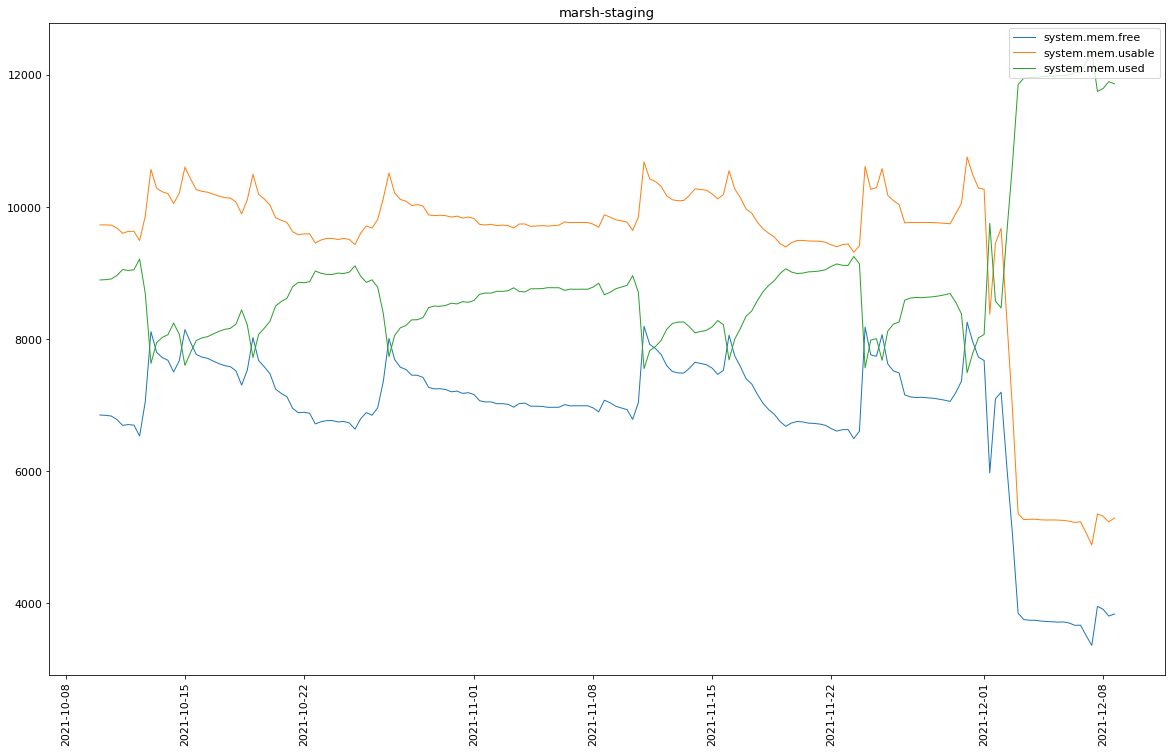

In [30]:
import matplotlib.pyplot as plt
chart = final.loc[final.client_env=='marsh-staging'].copy()
chart['system.mem.not_usable'] = chart['system.mem.total'] - chart['system.mem.usable']
chart_list = [x for x in chart.columns if x not in ['time','client_env']]
#chart_list = ['system.mem.free','system.mem.usable','system.mem.used','system.mem.cached','system.mem.commit_limit','system.mem.not_usable']
chart_list = ['system.mem.free','system.mem.usable','system.mem.used']
for c in chart_list[0:10]:
    plt.plot(chart['time'],chart[c],linewidth=1,label=c)

plt.legend(loc=1)
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams.update({'font.size': 11})
plt.xticks(rotation=90)
plt.title(list(chart.client_env.unique())[0])
plt.show()

In [72]:
#chart.iloc[:,0:12]
chart_list = [x for x in chart.columns if x not in ['time','client_env']]
chart[chart_list].describe().transpose()

count      mean      std       min       25%  \
system.mem.buffered         180.000   192.602   42.628   127.589   158.228   
system.mem.cached           180.000  2242.167  150.459  1941.635  2114.611   
system.mem.commit_limit     180.000  7873.219    0.000  7873.219  7873.219   
system.mem.committed_as     180.000  8155.292 1523.446  6990.167  7500.724   
system.mem.free             180.000  7790.590  378.333  6821.180  7506.703   
system.mem.page_tables      180.000    54.823    7.730    49.352    51.386   
system.mem.pct_usable       180.000     0.643    0.020     0.582     0.638   
system.mem.shared           180.000     0.090    0.000     0.090     0.090   
system.mem.slab             180.000   176.954   12.137   156.390   165.675   
system.mem.slab_reclaimable 180.000   132.299    8.450   116.868   123.978   
system.mem.total            180.000 15746.438    0.000 15746.437 15746.438   
system.mem.usable           180.000 10128.798  309.402  9167.194 10045.302   
system.mem.used             180.000  7955.849  378.334  6989.697  7723.165   
system.mem.not_usable       180.000  5617.640  309.402  4903.188  5479.981   

                                  50%       75%       max  
system.mem.buffered           180.828   228.755   303.685  
system.mem.cached            2169.426  2401.510  2440.223  
system.mem.commit_limit      7873.219  7873.219  7873.219  
system.mem.committed_as      7620.320  8082.974 14003.299  
system.mem.free              7801.000  8023.272  8756.740  
system.mem.page_tables         52.129    54.475    84.760  
system.mem.pct_usable           0.646     0.652     0.689  
system.mem.shared               0.090     0.090     0.090  
system.mem.slab               174.972   185.379   206.010  
system.mem.slab_reclaimable   133.285   140.466   149.953  
system.mem.total            15746.438 15746.438 15746.438  
system.mem.usable           10167.565 10266.457 10843.249  
system.mem.used              7945.437  8239.735  8925.257  
system.mem.not_usable        5578.872  5701.136  6579.244

In [70]:
clist1 = final.loc[final['system.mem.commit_limit']>final['system.mem.used']].client_env.unique()
clist2 = final.loc[final['system.mem.commit_limit']<final['system.mem.used']].client_env.unique()
[x for x in clist1 if x in clist2]

['cpc-production',
 'hancock-production',
 'ayco-uat',
 'nyc-doitt-1-stg-staging',
 'marsh-staging',
 'chil-crr-production',
 'ia-crr-production',
 'se2sbl-production',
 'smnyl-staging',
 'axa-uat',
 'scca-crr-production',
 'demo-fs-uat',
 'liu-ia-pre-production',
 'boa-staging',
 'kctn-crr-production',
 'demo-uat',
 'travelers-uat',
 'assurant-production',
 'voya-production',
 'tokiomarine-staging',
 'ia-crr-staging',
 'demo-ins-uat',
 'demo-pe-uat',
 'se2sbl-uat',
 'hcin-crr-production',
 'andino-production',
 'mmcdfd-staging',
 'liu-ia-production']

# Test Kubernetes vs System Metrics

In [13]:
big_list = api.Metric.list(int(time.time()) - 3600)
days = 30
values = [x for x in big_list['metrics'] if re.match('^system\.mem',x) or re.match('kubernetes\.memory',x)]
final = pd.DataFrame()
for value in values[0:]:
    test = api.Metric.query(start=int(time.time()) - 3600*24*(days), end=int(time.time()),
        query='avg:'+value+'{uq-environmentname:*} by {uq-environmentname}')

    test=test['series']
    env_list = [x['tag_set'][0] for x in test]
    env_list = [x for x in env_list if re.match('^.*ssgm.*$',x)]
    df = pd.DataFrame()

    for e in env_list:
        try:
            list1 = [x['pointlist'] for x in test if x['tag_set'][0]==e]
            flat_list = [item for sublist in list1 for item in sublist]
            df1 = pd.DataFrame(flat_list).rename(columns={0:'time',1:value})
            df1['time'] = pd.to_datetime(df1['time'].apply(lambda x: x*1000000))
            df1['client_env'] = re.sub('uq-environmentname:','',e)
            df = df.append(df1)
        except Exception as e:
            print('Could not append ' + value + ', error: ' + str(e))
    try:
        if len(final) > 0:
            final = final.merge(df,on=['client_env','time'],how='outer')
        else: final = df.copy()
    except Exception as e:
        print('Could not merge ' + value + ', error: ' + str(e))

Could not merge kubernetes.memory.capacity, error: 'client_env'


In [19]:
final['test'] = final['kubernetes.memory.usage']/final['kubernetes.memory.limits']
final.loc[final.client_env=='ssgm-production'].iloc[:,0:10]

time  kubernetes.memory.cache       client_env  \
2880 2021-10-31 04:00:00           4239276276.622  ssgm-production   
2881 2021-10-31 08:00:00           4209004209.778  ssgm-production   
2882 2021-10-31 12:00:00           4199381883.733  ssgm-production   
2883 2021-10-31 16:00:00           4199339575.467  ssgm-production   
2884 2021-10-31 20:00:00           4199414869.333  ssgm-production   
...                  ...                      ...              ...   
3055 2021-11-29 08:00:00           1394678535.111  ssgm-production   
3056 2021-11-29 12:00:00           1394640210.489  ssgm-production   
3057 2021-11-29 16:00:00           1394644992.000  ssgm-production   
3058 2021-11-29 20:00:00           1394674013.867  ssgm-production   
3059 2021-11-30 00:00:00           1394920991.464  ssgm-production   

      kubernetes.memory.limits  kubernetes.memory.requests  \
2880           16341008384.000             14730395648.000   
2881           16341008384.000             14730395648.000   
2882           16341008384.000             14730395648.000   
2883           16341008384.000             14730395648.000   
2884           16341008384.000             14730395648.000   
...                        ...                         ...   
3055           16341008384.000             14730395648.000   
3056           16341008384.000             14730395648.000   
3057           16341008384.000             14730395648.000   
3058           16341008384.000             14730395648.000   
3059           16341008384.000             14730395648.000   

      kubernetes.memory.rss  kubernetes.memory.sw_limit  \
2880         7102218252.800             16341008384.000   
2881         7132782556.444             16341008384.000   
2882         7166159974.400             16341008384.000   
2883         7195501484.089             16341008384.000   
2884         7214729316.978             16341008384.000   
...                     ...                         ...   
3055         6577315737.600             16341008384.000   
3056         6652122363.733             16341008384.000   
3057         6767626124.800             16341008384.000   
3058         6842336517.689             16341008384.000   
3059         6888135874.503             16341008384.000   

      kubernetes.memory.swap  kubernetes.memory.usage  \
2880                   0.000          11716375219.200   
2881                   0.000          11715543241.956   
2882                   0.000          11739554099.200   
2883                   0.000          11770211743.289   
2884                   0.000          11790883847.111   
...                      ...                      ...   
3055                   0.000           8319178766.222   
3056                   0.000           8404167780.978   
3057                   0.000           8534661694.578   
3058                   0.000           8621055310.222   
3059                   0.000           8675828438.018   

      kubernetes.memory.usage_pct  
2880                        0.717  
2881                        0.717  
2882                        0.718  
2883                        0.720  
2884                        0.722  
...                           ...  
3055                        0.509  
3056                        0.514  
3057                        0.522  
3058                        0.528  
3059                        0.531  

[180 rows x 10 columns]

In [21]:
final.loc[final.client_env=='ssgm-production',['kubernetes.memory.usage_pct','test']]

kubernetes.memory.usage_pct  test
2880                        0.717 0.717
2881                        0.717 0.717
2882                        0.718 0.718
2883                        0.720 0.720
2884                        0.722 0.722
...                           ...   ...
3055                        0.509 0.509
3056                        0.514 0.514
3057                        0.522 0.522
3058                        0.528 0.528
3059                        0.531 0.531

[180 rows x 2 columns]

In [24]:
x = 16295314773.333/1024**2
y = 16341008384.000/1024**2
print(x,y)

15540.423177083016 15584.0
